# Time series forecasting with Arima

Personal testing

## statsmodels

```
conda install -c conda-forge statsmodels
conda install statsmodels==0.12.1
```

In [15]:
import datetime
from datetime import date
import numpy as np
import pandas as pd
import statsmodels.api as sm

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2021-01-05 to 2021-02-13
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Variable  40 non-null     float64
dtypes: float64(1)
memory usage: 640.0 bytes


<AxesSubplot:xlabel='Date'>

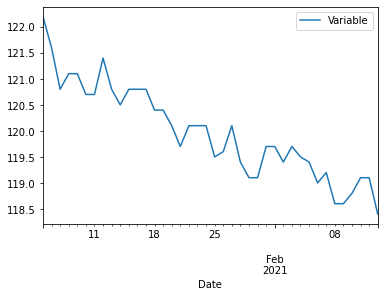

In [34]:
df = pd.read_csv('dataset.csv', parse_dates=['Date'], dayfirst=True, index_col=0)
df.info()
df.plot() # or 'Date','Variable'

# note: the index_col call above is important, if it's not there there's a world of relative pain
# to set the index to that column, and I think you have to delete the Date after you created an index with it:
# https://stackoverflow.com/questions/48473794/python-pandas-data-frame-format-index-issue

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

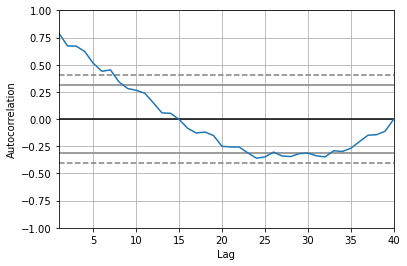

In [28]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

# Autocorrelation plots are a commonly used tool for checking randomness in a data set.
# This randomness is ascertained by computing autocorrelation for data values at varying time lags. 
# autocorrelation_plot: https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html
# set_index because: https://stackoverflow.com/questions/46528520/pandas-typeerror-unsupported-operand-types-for-timedelta-and-float
autocorrelation_plot(df)  #df.set_index('Date')

In [35]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(np.asarray(df), order=(5,1,0)) # what are these parameters?
model_fit = model.fit()

In [36]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -13.905
Date:                Sat, 13 Feb 2021   AIC                             39.810
Time:                        15:55:48   BIC                             49.792
Sample:                             0   HQIC                            43.392
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2165      0.219     -0.988      0.323      -0.646       0.213
ar.L2         -0.3503      0.177     -1.979      0.048      -0.697      -0.003
ar.L3          0.0307      0.210      0.146      0.8

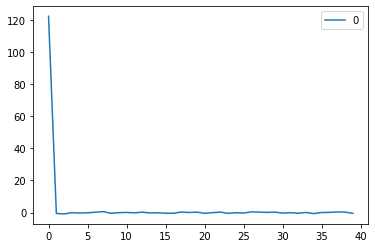

In [40]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

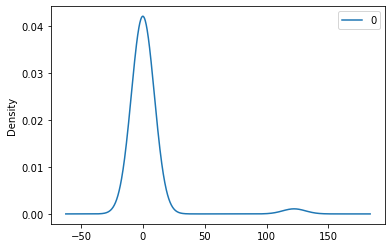

In [44]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

# Next, we get a density plot of the residual error values, suggesting the errors are Gaussian
# (and apparently centered on zero or close to it)

In [45]:
# summary stats of residuals
print(residuals.describe())

# The distribution of the residual errors is displayed. The results show that indeed there is a bias in the
# prediction (a non-zero mean in the residuals). --- jota: is this bad? why is it relevant?

                0
count   40.000000
mean     2.945898
std     19.342114
min     -0.876254
25%     -0.400475
50%     -0.089364
75%      0.208938
max    122.200000


## Try doing predictions

In [59]:
size

20

In [67]:
# evaluate an ARIMA model using a walk-forward validation
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# split into train and test sets
X = df.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [77]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0] # returns an array with 1 element, getting it
	predictions.append(yhat)
	expected = test[t]
	history.append(expected)
	print('predicted=%f, expected=%f' % (yhat, expected))

predicted=118.614969, expected=119.400000
predicted=119.377751, expected=119.700000
predicted=119.348661, expected=119.500000
predicted=119.335218, expected=119.400000
predicted=119.491379, expected=119.000000
predicted=119.422615, expected=119.200000
predicted=119.316319, expected=118.600000
predicted=118.678667, expected=118.600000
predicted=118.704689, expected=118.800000
predicted=118.698635, expected=119.100000
predicted=118.917468, expected=119.100000
predicted=118.891057, expected=118.400000


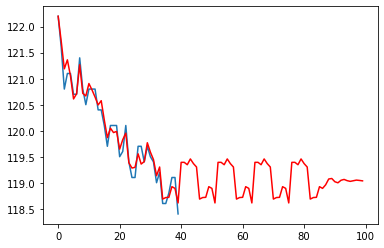

In [96]:
model_fit.predict(start=27, end=100)

pyplot.plot(X)
pyplot.plot(model_fit.predict(start=1, end=100), color='red') # adding , typ='levels' doesn't change anything
pyplot.show()

In [69]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.365


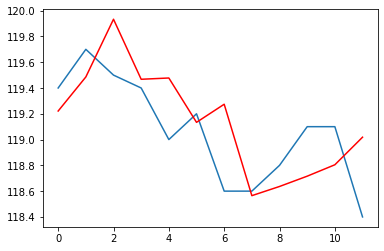

In [70]:
# plot forecasts against actual outcomes
# expected values - blue
# predictions - red
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## Old code/not used

In [83]:
df['dayOfYear'] = [dt.timetuple().tm_yday for dt in df['Date']]

In [93]:
results = sm.OLS(df['dayOfYear'], df['Variable']).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              dayOfYear   R-squared (uncentered):                   0.813
Model:                            OLS   Adj. R-squared (uncentered):              0.808
Method:                 Least Squares   F-statistic:                              169.5
Date:                Sat, 13 Feb 2021   Prob (F-statistic):                    8.88e-16
Time:                        14:31:34   Log-Likelihood:                         -155.18
No. Observations:                  40   AIC:                                      312.4
Df Residuals:                      39   BIC:                                      314.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Variable       0.2035      0.016     13.020      0.000       0.172       0.235
==============================================================================
Omnibus:                        8.338   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                2.397
Skew:                          -0.004   Prob(JB):                        0.302
Kurtosis:                       1.801   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""